In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../core/')
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, InterpolatedUnivariateSpline, UnivariateSpline
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
from matplotlib.lines import Line2D
from copy import deepcopy
from tools import *
from settings import *

### First, get all effective areas

In [3]:
from aeff_calculations import get_aeff_and_binnings, aeff_eval_e_sd

In [4]:
aeff_2d, log_ebins, ebins, sindec_bins, ra_bins = get_aeff_and_binnings("full")

emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)
ra_mids = get_mids(ra_bins)
ra_width = np.diff(ra_bins)

## get all detection efficiencies $\propto N_{detected}$ per fixed livetime

In [5]:
with open("../resources/detection_efficiencies.pckl", "rb") as f:
    tcks, _ = pickle.load(f)

#### scaling effective area ic->p1

In [6]:
cz, aic, ap1 = np.loadtxt("../resources/HUT.txt")
spl_a_ratio = UnivariateSpline(cz, ap1/aic, k=1, s=0)

#### scaling effective area ic->ic2

In [7]:
cz, ratio = np.loadtxt("../resources/ratio_IC_IC2.txt")
spl_a_ratio = UnivariateSpline(cz[::-1], ratio[::-1], k=1, s=0)

### Detection efficiency - IceCube only

phi0:  1e-18 (E/100TeV)^-gamma / GeV cm^2 s sr
gamma: 1.5 	 nevents IC: 2226.33 	 nevents IC2: 2660.12 	 ratio: 1.19
gamma: 2.0 	 nevents IC: 1152.20 	 nevents IC2: 1401.05 	 ratio: 1.22
gamma: 2.3 	 nevents IC: 1767.69 	 nevents IC2: 2169.41 	 ratio: 1.23
gamma: 2.5 	 nevents IC: 2930.47 	 nevents IC2: 3612.45 	 ratio: 1.23
gamma: 3.0 	 nevents IC: 17803.35 	 nevents IC2: 22103.03 	 ratio: 1.24


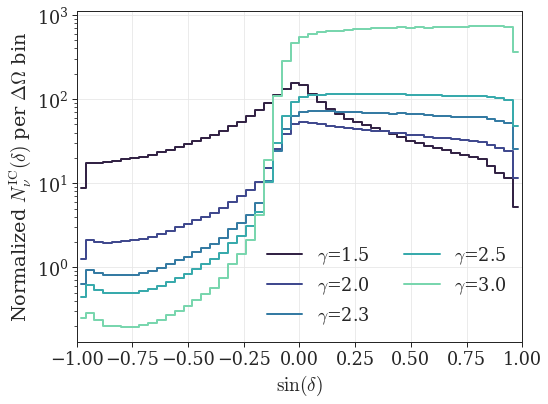

In [11]:
gammas = [1.5, 2.0, 2.3, 2.5, 3.]
sns.set_palette("mako", n_colors=len(gammas))
fig, ax = plt.subplots(figsize=(8,6))
print("phi0: ", PHI_0, "(E/100TeV)^-gamma / GeV cm^2 s sr")
for gamma in gammas:
    eff = np.exp(tcks[gamma]["IceCube"](sindec_mids)) * LIVETIME * PHI_0
    p = ax.plot(sindec_mids, eff, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid")
    print(
        "gamma:", gamma,
        "\t nevents IC: {:1.2f}".format(np.sum(eff)),
        "\t nevents IC2: {:1.2f}".format(np.sum(eff * spl_a_ratio(sindec_mids))),
        "\t ratio: {:1.2f}".format(np.sum(eff * spl_a_ratio(sindec_mids)) / np.sum(eff))
    )
    
ax.legend(ncol=2, frameon=False, loc=4)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'Normalized $N_{\nu}^{\rm IC}(\delta)$ per $\Delta \Omega$ bin')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
fig.tight_layout()

IceCube:
gamma: 1.5 	 	 FoV >90%: 0.15607770320354009 pi 	 FoV >95%: 0.15607770320354009 pi
gamma: 2.0 	 	 FoV >90%: 0.3809711322223621 pi 	 FoV >95%: 0.15878856482396886 pi
gamma: 2.3 	 	 FoV >90%: 1.0779653145023385 pi 	 FoV >95%: 0.780915802190252 pi
gamma: 2.5 	 	 FoV >90%: 1.706309589029952 pi 	 FoV >95%: 1.332166026922308 pi
gamma: 3.0 	 	 FoV >90%: 1.3800003223334874 pi 	 FoV >95%: 1.0092164751716162 pi


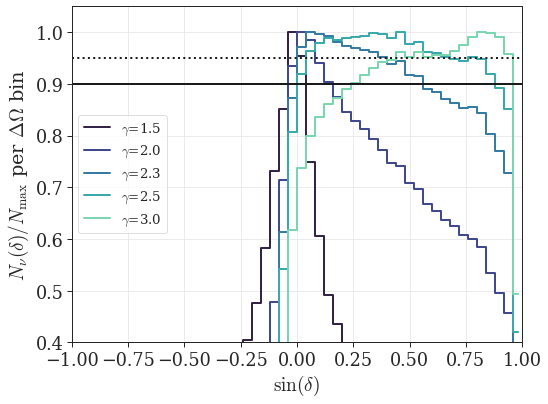

Energy: around 10 TeV 	 FoV >90%: 1.453287517956676 pi 	 FoV >95%: 0.8606337259877596 pi
Energy: around 100 TeV 	 FoV >90%: 0.37846716370650674 pi 	 FoV >95%: 0.15740969170936675 pi
Energy: around 1 PeV 	 FoV >90%: 0.22907417998267537 pi 	 FoV >95%: 0.15638961136091134 pi


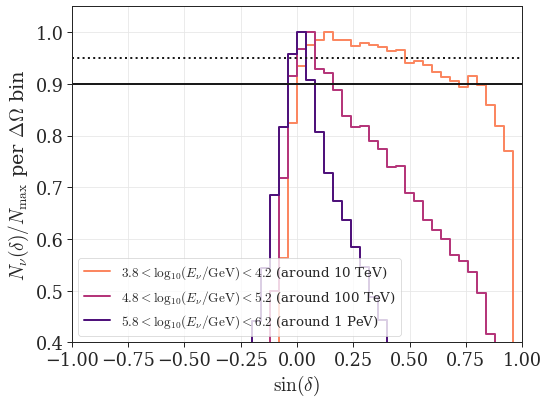

In [7]:
## FoV

gammas = [1.5, 2.0, 2.3, 2.5, 3.]
sns.set_palette("mako", n_colors=len(gammas))

fig, ax = plt.subplots(figsize=(8,6))
print("IceCube:")
aeff_factor = aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
for gamma in gammas:
    eff = np.sum(aeff_factor * (emids/E_NORM)**(-gamma), axis=-1)
    eff /= np.max(eff)
    p = ax.plot(sindec_mids, eff, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid")
    print(
        "gamma:", gamma, 
        "\t \t FoV >90%:", np.sum(sindec_width[eff>=0.9]) * 2, "pi",
        "\t FoV >95%:", np.sum(sindec_width[eff>=0.95]) * 2, "pi",
    )
ax.legend(loc=6, fontsize="x-small")
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
ax.set_xlim(-1, 1)
ax.set_ylim(0.4, 1.05)
ax.axhline(0.90, color="k")
ax.axhline(0.95, ls=":", color="k")
fig.tight_layout()
plt.show()

sns.set_palette("magma_r", n_colors=3)
ref_logE = np.array([4, 5, 6])
ref_logE_names = np.array(["10 TeV", "100 TeV", "1 PeV"])


fig, ax = plt.subplots(figsize=(8,6))

for re, rn in zip(ref_logE, ref_logE_names):
    binminus = re - 0.2
    binplus = re + 0.2
    eff_E = np.mean(aeff_factor[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
    eff_E /= np.max(eff_E)
    ax.plot(
        sindec_mids, eff_E, ds="steps-mid",
        label=fr'${binminus} < \log_{{10}}(E_\nu / {{\rm GeV}}) <{binplus}$ (around {rn})')
    print(
        "Energy: around", rn,
        "\t FoV >90%:", np.sum(sindec_width[eff_E>=0.9]) * 2, "pi",
        "\t FoV >95%:", np.sum(sindec_width[eff_E>=0.95]) * 2, "pi",
    )
ax.legend(loc=3, fontsize="x-small")
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
ax.set_xlim(-1, 1)
ax.set_ylim(0.4, 1.05)
ax.axhline(0.90, color="k")
ax.axhline(0.95, ls=":", color="k")
fig.tight_layout()

### FoV comparison to other locations (time-integrated) and PLEnuM: relative to max of resp. detector

In [10]:
## FoV
threshold = 0.9
gammas = [1.5, 2.0, 2.3, 2.5, 3.]
for key in aeff_2d:
    print(key)
    aeff_factor = aeff_eval_e_sd(aeff_2d[key], sindec_width, ewidth, ra_width)
    for gamma in gammas:
        eff = np.sum(aeff_factor * (emids/E_NORM)**(-gamma), axis=-1)
        eff /= np.max(eff)
        print(
            "gamma:", gamma, 
            "\t FoV >", int(threshold*100), "% of max.:", np.sum(sindec_width[eff>=threshold]) * 2, "pi",
        )
    print(" = " * 20)

Plenum-1
gamma: 1.5 	 FoV > 90 % of max.: 0.2399647039527789 pi
gamma: 2.0 	 FoV > 90 % of max.: 0.4800188037582845 pi
gamma: 2.3 	 FoV > 90 % of max.: 1.2000188870093247 pi
gamma: 2.5 	 FoV > 90 % of max.: 0.5601085397110266 pi
gamma: 3.0 	 FoV > 90 % of max.: 0.4000021437029828 pi
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
IceCube
gamma: 1.5 	 FoV > 90 % of max.: 0.15982959840632302 pi
gamma: 2.0 	 FoV > 90 % of max.: 0.4000217452746496 pi
gamma: 2.3 	 FoV > 90 % of max.: 1.120121525632221 pi
gamma: 2.5 	 FoV > 90 % of max.: 1.7599608136252969 pi
gamma: 3.0 	 FoV > 90 % of max.: 1.4398847671104684 pi
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
P-ONE
gamma: 1.5 	 FoV > 90 % of max.: 0.9600568354660164 pi
gamma: 2.0 	 FoV > 90 % of max.: 0.5600649878134814 pi
gamma: 2.3 	 FoV > 90 % of max.: 0.879878474367779 pi
gamma: 2.5 	 FoV > 90 % of max.: 0.799997141734675 pi
gamma: 3.0 	 FoV > 90 % of max.: 0.3200022656081549 pi
 =  =  =  =  =  =  =  =  =  =  =

### FoV comparison to other locations (time-integrated) and PLEnuM: relative to max of IceCube

Plenum-1
gamma: 2.0 	 FoV > 50 % of max.: 3.439891460288973 pi
IceCube
gamma: 2.0 	 FoV > 50 % of max.: 1.9200107183749142 pi
P-ONE
gamma: 2.0 	 FoV > 50 % of max.: 2.96014079848793 pi
KM3NeT
gamma: 2.0 	 FoV > 50 % of max.: 3.1201215256322206 pi
Baikal-GVD
gamma: 2.0 	 FoV > 50 % of max.: 2.8000582744745297 pi
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 
Plenum-1
gamma: 2.5 	 FoV > 50 % of max.: 3.359906757444838 pi
IceCube
gamma: 2.5 	 FoV > 50 % of max.: 2.0800519055244306 pi
P-ONE
gamma: 2.5 	 FoV > 50 % of max.: 2.239927136325676 pi
KM3NeT
gamma: 2.5 	 FoV > 50 % of max.: 2.1600499047496173 pi
Baikal-GVD
gamma: 2.5 	 FoV > 50 % of max.: 2.239927136325676 pi
 =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  =  = 


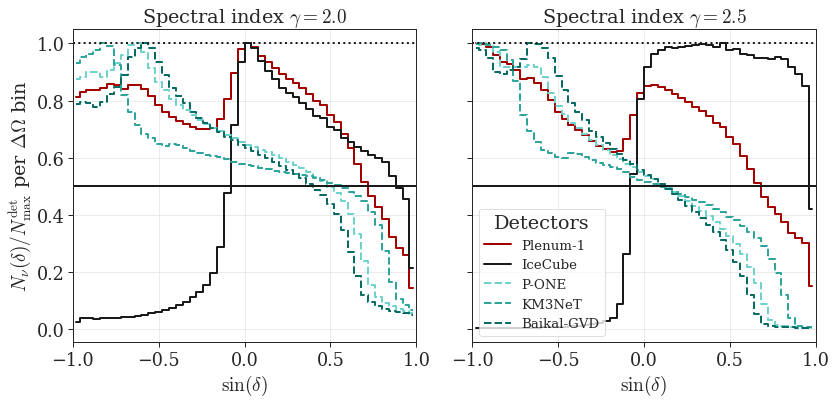

In [19]:
## FoV
threshold = 0.5 
gammas = [2.0, 2.5] #[1.5, 2.0, 2.3, 2.5, 3.]
max_ic_nev = {}
ic_aeff_factor = aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
for gamma in gammas:
    max_ic_nev[gamma] = np.max(np.sum(ic_aeff_factor * (emids/E_NORM)**(-gamma), axis=-1))
fig, axes = plt.subplots(ncols=2, figsize=(12,6), sharey=True)
    
for i, gamma in enumerate(gammas):
    ax = axes[i]
    for key in aeff_2d:
        if "2" in key: continue
        print(key)
        aeff_factor = aeff_eval_e_sd(aeff_2d[key], sindec_width, ewidth, ra_width)
        eff = np.sum(aeff_factor * (emids/E_NORM)**(-gamma), axis=-1)
        eff /= np.max(eff) #max_ic_nev[gamma]
        p = ax.plot(
            sindec_mids, eff, 
            label=key,
            ds="steps-mid",
            color=poles[key]["color"],
            ls=poles[key]["ls"],
        )
        print(
            "gamma:", gamma, 
            "\t FoV >", int(threshold*100), "% of max.:", np.sum(sindec_width[eff>=threshold]) * 2, "pi",
        )
    print(" = " * 20)
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_xlim(-1, 1)
    #ax.set_ylim(0.4, 1.05)
    ax.set_title(r"Spectral index $\gamma={}$".format(gamma))
    ax.axhline(threshold, color="k")
    ax.axhline(1, color="k", ls=":")
axes[0].set_ylabel(r'$N_{\nu}(\delta) / N_{\max}^{\rm det} $ per $\Delta \Omega$ bin')
ax.legend(loc=3, fontsize="x-small", title="Detectors") #loc=6
fig.tight_layout()


### P-ONE with scaling

In [38]:
from aeff_calculations import setup_aeff_grid, aeff_rotation

In [39]:
grid2d, eq_coords = setup_aeff_grid(
    aeff_2d["IceCube"] * spl_a_ratio(sindec_mids), sindec_mids, ra_mids, ra_width)
aeff_p1_averaged = aeff_rotation(poles["P-ONE"]["lat"], poles["P-ONE"]["lon"], eq_coords, grid2d, ra_width)

In [40]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("mako", n_colors=16))
from tools import get_mids

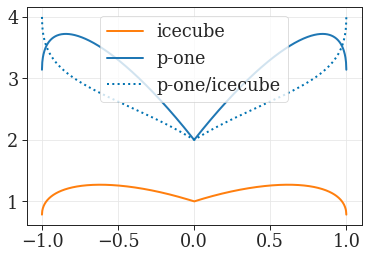

In [41]:
plt.plot(cz, aic*1E-6, label="icecube", color="tab:orange")
plt.plot(cz, ap1*1E-6, label="p-one", color="tab:blue")
plt.plot(cz, ap1/aic, label="p-one/icecube", ls=":")
plt.legend()

phi0:  1e-18
IceCube:
gamma: 1.5 , nevents: 2226.327864086702
gamma: 2.0 , nevents: 1152.1997169545382
gamma: 2.5 , nevents: 2930.470393588115
gamma: 3.0 , nevents: 17803.34672990627
P-ONE:
gamma: 1.5 , nevents: 5333.569525737379
gamma: 2.0 , nevents: 2895.1084578056384
gamma: 2.5 , nevents: 7604.51411067057
gamma: 3.0 , nevents: 46948.37162201037


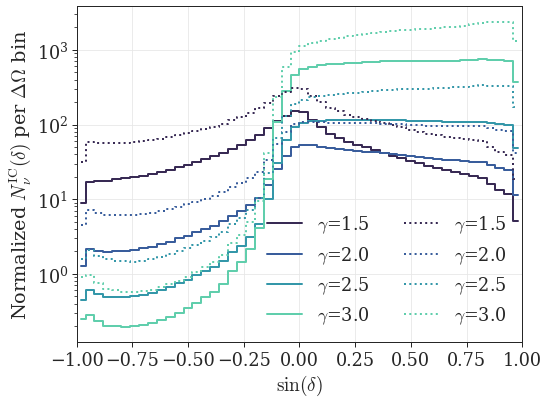

In [13]:
gammas = [1.5, 2.0, 2.5, 3.]
sns.set_palette("mako", n_colors=len(gammas))
fig, ax = plt.subplots(figsize=(8,6))
print("phi0: ", PHI_0)
print("IceCube:")
aeff_factor = aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
for gamma in gammas:
    eff = np.sum(aeff_factor * (emids/E_NORM)**(-gamma), axis=-1) * LIVETIME * PHI_0
    p = ax.plot(sindec_mids, eff, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid")
    print("gamma:", gamma, ", nevents:", np.sum(eff))
    
print("P-ONE:")
aeff_factor = aeff_eval_e_sd(aeff_2d["IceCube"] * spl_a_ratio(sindec_mids), sindec_width, ewidth, ra_width)
for gamma in gammas:
    eff = np.sum(aeff_factor * (emids/E_NORM)**(-gamma), axis=-1) * LIVETIME * PHI_0
    p = ax.plot(sindec_mids, eff, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid", ls=":")
    print("gamma:", gamma, ", nevents:", np.sum(eff))
    
ax.legend(ncol=2, frameon=False, loc=4)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'Normalized $N_{\nu}^{\rm IC}(\delta)$ per $\Delta \Omega$ bin')
ax.set_yscale('log')
ax.set_xlim(-1, 1)
fig.tight_layout()



## FoV comparison icecube vs pone-instantaneous

Spectrum weighted:
gamma: 1.5 	 	 FoV IC >90%: 0.156 pi 	 	 FoV P-ONE >90%: 0.156 pi
gamma: 2.0 	 	 FoV IC >90%: 0.381 pi 	 	 FoV P-ONE >90%: 1.134 pi
gamma: 2.5 	 	 FoV IC >90%: 1.706 pi 	 	 FoV P-ONE >90%: 0.841 pi
gamma: 3.0 	 	 FoV IC >90%: 1.380 pi 	 	 FoV P-ONE >90%: 0.387 pi
Energy bin:
Energy: 3.8 < log10(E_nu / GeV) <4.2 (around 10 TeV) 	 FoV IC >90%: 1.453 pi 	 FoV P-ONE >90%: 0.912 pi
Energy: 4.8 < log10(E_nu / GeV) <5.2 (around 100 TeV) 	 FoV IC >90%: 0.378 pi 	 FoV P-ONE >90%: 0.829 pi
Energy: 5.8 < log10(E_nu / GeV) <6.2 (around 1 PeV) 	 FoV IC >90%: 0.229 pi 	 FoV P-ONE >90%: 0.231 pi


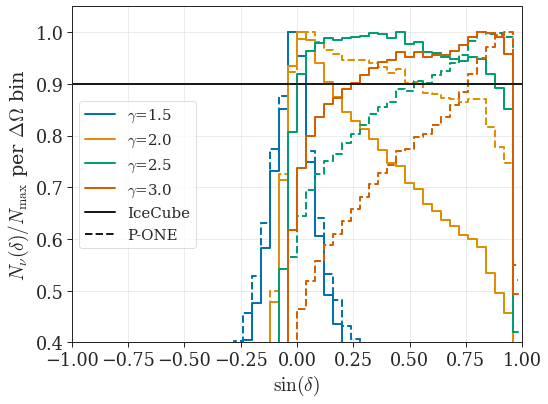

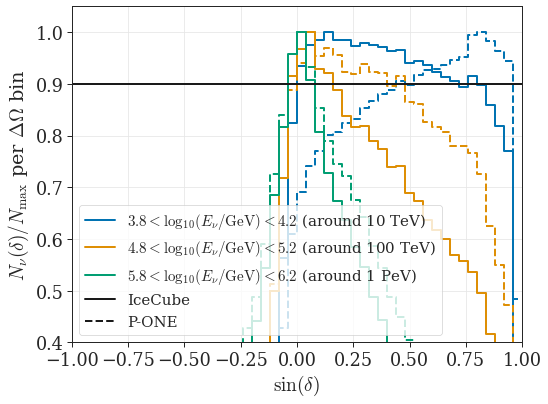

In [15]:
gammas = [1.5, 2.0, 2.5, 3.]
sns.set_palette("colorblind", n_colors=len(gammas))

aeff_factor_p1 = aeff_eval_e_sd(aeff_2d["IceCube"] * spl_a_ratio(sindec_mids), sindec_width, ewidth, ra_width)
aeff_factor_ic = aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)

fig, ax = plt.subplots(figsize=(8,6))
print("Spectrum weighted:")
for gamma in gammas:
    eff_ic = np.sum(aeff_factor_ic * (emids/E_NORM)**(-gamma), axis=-1)
    eff_ic /= np.max(eff_ic)
    p = ax.plot(sindec_mids, eff_ic, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid")
    
    eff_p1 = np.sum(aeff_factor_p1 * (emids/E_NORM)**(-gamma), axis=-1)
    eff_p1 /= np.max(eff_p1)
    ax.plot(sindec_mids, eff_p1, 
            ds="steps-mid", ls="--", color=p[0].get_color())
    print(
        "gamma:", gamma, 
        "\t \t FoV IC >90%: {:1.3f} pi".format(np.sum(sindec_width[eff_ic>=0.9]) * 2),
        "\t \t FoV P-ONE >90%: {:1.3f} pi".format(np.sum(sindec_width[eff_p1>=0.9]) * 2),
    )
handles, labels = ax.get_legend_handles_labels()
handles.extend(
    [matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="-",
        lw=2, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="--",
        lw=2, label="P-ONE"),
    ]
)
ax.legend(handles=handles, loc=6, fontsize=15)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
ax.set_xlim(-1, 1)
ax.set_ylim(0.4, 1.05)
ax.axhline(0.90, color="k")
#ax.axhline(0.95, ls=":", color="k")
fig.tight_layout()

ref_logE = np.array([4, 5, 6])
binsize = 0.2
ref_logE_names = np.array(["10 TeV", "100 TeV", "1 PeV"])

print("Energy bin:")
fig, ax = plt.subplots(figsize=(8,6))
for re, rn in zip(ref_logE, ref_logE_names):
    binminus = re - binsize
    binplus = re + binsize
    eff_ic = np.mean(aeff_factor_ic[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
    eff_ic /= np.max(eff_ic)
    p= ax.plot(
        sindec_mids, eff_ic, ds="steps-mid",
        label=fr'${binminus} < \log_{{10}}(E_\nu / {{\rm GeV}}) <{binplus}$ (around {rn})')
    eff_p1 = np.mean(aeff_factor_p1[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
    eff_p1 /= np.max(eff_p1)
    ax.plot(
        sindec_mids, eff_p1, ds="steps-mid",
        ls="--", color=p[0].get_color())
    print(
        f"Energy: {binminus} < log10(E_nu / GeV) <{binplus} (around {rn})",
        "\t FoV IC >90%: {:1.3f} pi".format(np.sum(sindec_width[eff_ic>=0.9]) * 2),
        "\t FoV P-ONE >90%: {:1.3f} pi".format(np.sum(sindec_width[eff_p1>=0.9]) * 2),
    )
handles, labels = ax.get_legend_handles_labels()
handles.extend(
    [matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="-",
        lw=2, label="IceCube"),
    matplotlib.lines.Line2D(
        range(1), range(1), 
        color="k", ls="--",
        lw=2, label="P-ONE"),
    ]
)
ax.legend(handles=handles, loc=3, fontsize=15)
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
ax.set_xlim(-1, 1)
ax.set_ylim(0.4, 1.05)
ax.axhline(0.90, color="k")
fig.tight_layout()

## FoV comparison icecube vs pone-average

In [8]:
gammas = [1.5, 2.0, 2.5, 3.]
sns.set_palette("colorblind", n_colors=len(gammas))
#ref_sens_eff = 0.5
aeff_factor_p1 = aeff_eval_e_sd(aeff_2d["IceCube"] * spl_a_ratio(sindec_mids), sindec_width, ewidth, ra_width)
aeff_factor_p1_avg = aeff_eval_e_sd(aeff_p1_averaged, sindec_width, ewidth, ra_width)
aeff_factor_ic = aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
for ref_sens_eff in [0.5, 0.7, 0.9]:
    fig, ax = plt.subplots(figsize=(8,6))
    print("Spectrum weighted:")
    for gamma in gammas:
        eff_ic = np.sum(aeff_factor_ic * (emids/E_NORM)**(-gamma), axis=-1)
        eff_ic /= np.max(eff_ic)
        p = ax.plot(sindec_mids, eff_ic, label=r'$\gamma$={0:.1f}'.format(gamma), ds="steps-mid")

        eff_p1 = np.sum(aeff_factor_p1 * (emids/E_NORM)**(-gamma), axis=-1)
        eff_p1 /= np.max(eff_p1)
        ax.plot(sindec_mids, eff_p1, 
                ds="steps-mid", ls="--", color=p[0].get_color())
        eff_p1_avg = np.sum(aeff_factor_p1_avg * (emids/E_NORM)**(-gamma), axis=-1)
        eff_p1_avg /= np.max(eff_p1_avg)
        ax.plot(sindec_mids, eff_p1_avg, 
                ds="steps-mid", ls=":", color=p[0].get_color())
        print(
            "gamma:", gamma, 
            "\t FoV IC >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_ic>=ref_sens_eff]) * 2), # eff_ic[eff_ic>=0.9] * 
            "\t FoV P-ONE >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_p1>=ref_sens_eff]) * 2), # eff_p1[eff_p1>=0.9] * 
            "\t FoV P-ONE average >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_p1_avg>=ref_sens_eff]) * 2), # eff_p1[eff_p1>=0.9] * 
        )
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(
        [matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls="-",
            lw=2, label="IceCube"),
        matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls="--",
            lw=2, label="P-ONE inst."),
        matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls=":",
            lw=2, label="P-ONE avg."),
        ]
    )
    ax.legend(handles=handles, loc=6, fontsize=15)
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.4, 1.05)
    ax.axhline(ref_sens_eff, color="k")
    fig.tight_layout()

    ref_logE = np.array([4, 5, 6])
    binsize = 0.2
    ref_logE_names = np.array(["10 TeV", "100 TeV", "1 PeV"])

    print("Energy bin:")
    fig, ax = plt.subplots(figsize=(8,6))
    for re, rn in zip(ref_logE, ref_logE_names):
        binminus = re - binsize
        binplus = re + binsize
        eff_ic = np.mean(aeff_factor_ic[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
        eff_ic /= np.max(eff_ic)
        p= ax.plot(
            sindec_mids, eff_ic, ds="steps-mid",
            label=fr'${binminus} < \log_{{10}}(E_\nu / {{\rm GeV}}) <{binplus}$ (around {rn})')
        eff_p1 = np.mean(aeff_factor_p1[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
        eff_p1 /= np.max(eff_p1)
        ax.plot(
            sindec_mids, eff_p1, ds="steps-mid",
            ls="--", color=p[0].get_color())
        eff_p1_avg = np.mean(aeff_factor_p1_avg[:,np.logical_and(log_ebins >= binminus, log_ebins < binplus)[:-1]], axis=-1)
        eff_p1_avg /= np.max(eff_p1_avg)
        ax.plot(
            sindec_mids, eff_p1_avg, ds="steps-mid",
            ls=":", color=p[0].get_color())
        print(
            f"Energy: {binminus}<log10(E_nu/GeV)<{binplus} ({rn})",
            "\t FoV IC >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_ic>=ref_sens_eff]) * 2), # eff_ic[eff_ic>=0.9] * 
            "\t FoV P-ONE >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_p1>=ref_sens_eff]) * 2), # eff_p1[eff_p1>=0.9] * 
            "\t FoV P-ONE average >{}%: {:1.3f} pi".format(
                int(ref_sens_eff*100), np.sum(sindec_width[eff_p1_avg>=ref_sens_eff]) * 2), # eff_p1[eff_p1>=0.9] * 
        )
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(
        [matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls="-",
            lw=2, label="IceCube"),
        matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls="--",
            lw=2, label="P-ONE inst."),
        matplotlib.lines.Line2D(
            range(1), range(1), 
            color="k", ls=":",
            lw=2, label="P-ONE avg."),
        ]
    )
    ax.legend(handles=handles, loc=3, fontsize=15)
    ax.set_xlabel(r'$\sin(\delta)$')
    ax.set_ylabel(r'$N_{\nu}(\delta) / N_{\max} $ per $\Delta \Omega$ bin')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0.4, 1.05)
    ax.axhline(ref_sens_eff, color="k")
    fig.tight_layout()
    plt.show()

NameError: name 'spl_a_ratio' is not defined